Getting the pickle files constructed using Monte carlo simulation : check the pickles_generation.ipynb for details

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import openpyxl
import statsmodels.api as sm
from scipy.stats import t
from multiprocessing import Pool
import os
from statsmodels.tsa.arima.model import ARIMA
import pickle
from statsmodels.tsa.stattools import adfuller
from itertools import combinations_with_replacement, combinations
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline
from statsmodels.stats.diagnostic import acorr_ljungbox



In [105]:
#Getting the constructed dataframe 
with open('./pickles/data_prices.pkl', 'rb') as file:
    data_prices = pickle.load(file)

In [106]:
# Pickle files :
#) Assesing the stationarity of TS using the constructed critical values with MC simulations 
# Load t_stat_array from a pickle file
with open('./pickles/t_stat_array.pkl', 'rb') as file:
    t_stat_array = pickle.load(file)

# Load critical_vals from a pickle file
with open('./pickles/critical_vals.pkl', 'rb') as file:
    critical_vals = pickle.load(file)

In [107]:
# Pickle files :
#) Assesing the co-integration of TS using the constructed critical values with MC simulations 
# Load t_stat_array from a pickle file
with open('./pickles/t_stat_cointegration_array.pkl', 'rb') as file:
    t_stat_cointegration_array = pickle.load(file)

# Load critical_vals from a pickle file
with open('./pickles/critical__cointegration_vals.pkl', 'rb') as file:
    critical_cointegration_vals = pickle.load(file)

In [108]:
#Testing for stationarity for each asset in our dataframe data_prices
#Recall H0 : no stationarity, we simulated random walks, hence if the t_computed is in the rejection region -> the Series is stationary
stationary_TS = []
non_stationary_TS = []
for stock in data_prices.columns:
    prices = data_prices[stock]
    
    # Compute log prices
    log_prices = np.log(prices)
    
    # Shift log prices to get lagged values
    log_prices_shifted = log_prices.shift(1)

    # Drop the first NaN value resulting from the shift
    log_prices = log_prices[1:]
    log_prices_shifted = log_prices_shifted[1:]

    # Calculate the difference in log prices
    delta_log_prices = log_prices - log_prices_shifted

    # Run regression: delta_log_prices on a constant and lagged log prices
    model = sm.OLS(delta_log_prices, sm.add_constant(log_prices_shifted))
    res = model.fit()

    # Assess the stationarity based on the 5% quantile
    # Reject the null hypothesis (series is stationary) if the t-statistic is more negative than the critical value
    if res.tvalues.iloc[1] < critical_vals["5%-Quantile"]:  # Check direction based on typical DF output
        stationary_TS.append(stock)
    else:
        non_stationary_TS.append(stock)


In [109]:
#Testing for cointegration falpha_beta = []or each asset in our dataframe data_prices
#Recall H0 : no cointegration, we simulated random walks, hence if the t_computed is in the rejection region -> Co-integration
# We take the non_stationary_TS
#The two directions should be assesed namely : A->B (B->A) is not needed since co-integration is symmetrical

pairs_assets = combinations(non_stationary_TS, 2)

dict_pairs_alpha_beta, dict_pairs_tstat = {}, {}

for pairs in pairs_assets : 
    
    #running a simple regression
    log_prices_A, log_prices_B = data_prices[pairs[0]], data_prices[pairs[1]]
    model_linear_regression = sm.OLS(log_prices_A, sm.add_constant(log_prices_B))
    results = model_linear_regression.fit()
    alpha, beta = results.params.iloc[0], results.params.iloc[1]
    alpha_beta = [alpha,beta]
    residuals_linear_regression = results.resid

    dfuller_test = adfuller(residuals_linear_regression)
    if dfuller_test[0] < critical_cointegration_vals['5%-Quantile'] :
        # cointegration exists at 5% significance level
        dict_pairs_alpha_beta[pairs] = alpha_beta
        dict_pairs_tstat[pairs] = dfuller_test[0]
    else :
        continue    

The smallest (most negative) Dickey-Fuller t-statistic, which indicates the strongest evidence against the null hypothesis of no cointegration and, therefore, the strongest evidence for cointegration.

In [110]:
most_cointegrated_pair = min(dict_pairs_tstat, key=dict_pairs_tstat.get)
print(most_cointegrated_pair)

('ICTL.HTLS.GP.', 'BOOKING HOLDINGS')


* InterContinental Hotels Group Plc and Booking holdings 
* Economicallly very intuitive 
* The strong cointegration suggests that any deviation from their long-term pricing relationship is likely temporary. Such deviations might occur due to company-specific news, different operational efficiencies, or geographic exposure but are expected to correct over time as both companies are ultimately influenced by the same underlying travel demand dynamics. 

Text(0, 0.5, 'Close price')

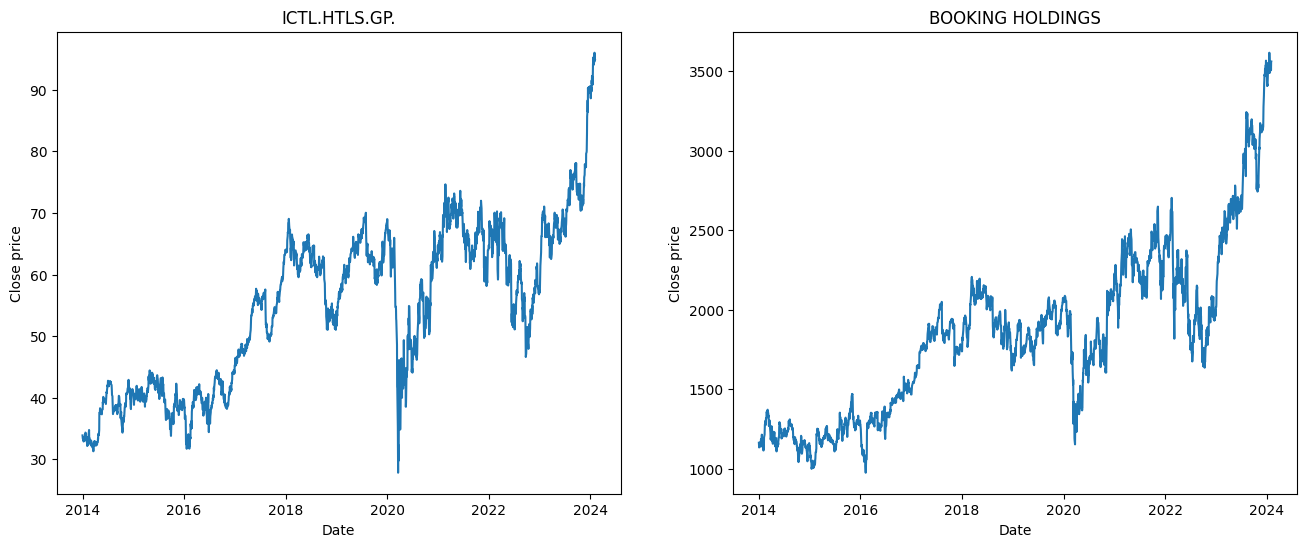

In [111]:
# Plotting both prices in two plots because the magintude of price is not the same
fig, ax = plt.subplots(1,2 ,figsize=(16,6))
ax[0].plot(data_prices[most_cointegrated_pair[0]])
ax[0].set_title(most_cointegrated_pair[0])
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Close price")


ax[1].plot(data_prices[most_cointegrated_pair[1]])
ax[1].set_title(most_cointegrated_pair[1])
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Close price")

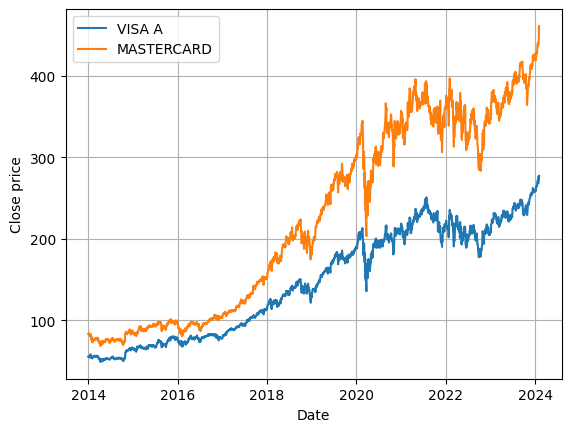

In [112]:
# Plotting both prices for VISA and Master Card
plt.plot(data_prices.index, data_prices["VISA"], label = "VISA A")
plt.plot(data_prices.index, data_prices["MASTERCARD"], label = "MASTERCARD")
plt.xlabel("Date")
plt.ylabel("Close price")
plt.grid()
plt.legend()
plt.show()

The first step is to define the spread between the prices that we will use
as signal for trading :
* Let the pair of assets (A,B) be cointegrated : $p_{t}^{A} = \alpha + \beta p_{t}^{B} + z_{t}$ (Use prices instead of log prices for simplicity)
* The spread is defined as $z_{t} = p_{t}^{A} - \alpha - \beta p_{t}^{B}  $
* The spread (or signal) is normalized as : $z_{normalized} = \frac{z_{t}}{\sigma(z_{t})}$
* The main property of $z_t$ is its mean reversion, that is $z_t$ the spread will tend to return to its historical mean. Deviation from the historical mean are just temporary
* Interpretation of $z_t >>0$ : If $z_t$ is significantly greater than zero. it indicates that the price of asset AA (adjusted for the intercept $\alpha$) is currently much higher than would be expected based on the price of asset BB. This can be interpreted as asset AA being overpriced relative to asset BB based on their historical pricing relationship.
* $z_{t} >> 0 => p_{t}^{A} >> \alpha + \beta p_{t}^{B}$
* Statistical arbitrage in this context involves exploiting the mean-reverting property of ztzt​. When ztzt​ is significantly positive (indicating that asset AA is overpriced relative to asset BB, or conversely, BB is underpriced relative to AA), a trader could potentially:

Sell asset A (short): The trader expects that asset AA's price will decrease, or at least grow less rapidly than asset BB's price, as the spread ztzt​ reverts to its mean.
Buy asset B (long): Simultaneously, buying asset BB capitalizes on its relatively lower price, expecting it to increase or decrease less than A as the spread normalizes.

The strategy aims to profit regardless of the direction of the market movement, relying on the relative movement of the two assets towards their historical equilibrium. This method can be profitable in a range of market conditions, particularly when market inefficiencies cause prices to diverge temporarily from their historical or expected relationships.

In [113]:
# Compute the spread normalized betweem our pairs of assets.
#Run a regression to get the alpha and beta parameters

p_t_A = data_prices['ICTL.HTLS.GP.']            #Prices of asset A 
p_t_B = data_prices['BOOKING HOLDINGS']         #Prices of asset B

#Run regression to estimate alpha and beta

model = sm.OLS(p_t_A, sm.add_constant(p_t_B))
res = model.fit()
print(res.summary())
alpha, beta = res.params[0], res.params[1]


#Compute the spread :
z_t = p_t_A - alpha - beta * p_t_B

#Comute the volatility of the spread
vol_z_t = z_t.std()

#Normalized spread
z_t_normalized = z_t/vol_z_t

                            OLS Regression Results                            
Dep. Variable:          ICTL.HTLS.GP.   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                 1.624e+04
Date:                Wed, 24 Apr 2024   Prob (F-statistic):               0.00
Time:                        16:04:50   Log-Likelihood:                -7882.5
No. Observations:                2633   AIC:                         1.577e+04
Df Residuals:                    2631   BIC:                         1.578e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.0194      0.341  

/tmp/ipykernel_6081/861209450.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha, beta = res.params[0], res.params[1]


Text(0.5, 1.0, 'Normalized spread between BOOKING HOLDINGS, Intercontinental ')

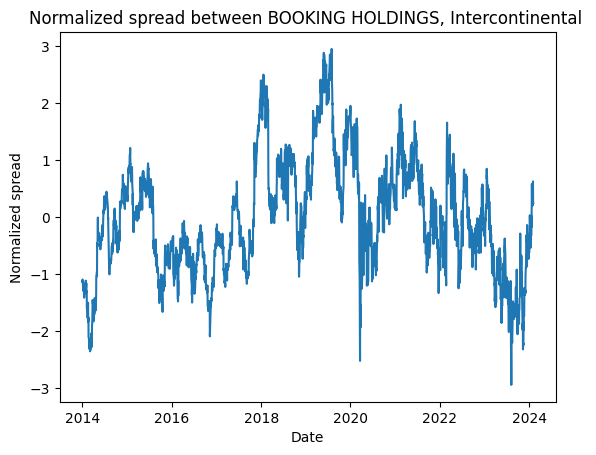

In [114]:
#Plotting the normalized spread

plt.plot(z_t_normalized)
plt.xlabel("Date")
plt.ylabel("Normalized spread")
plt.title("Normalized spread between BOOKING HOLDINGS, Intercontinental ")

Ljung-Box Q test :
* $H_0$ : The data are indepently distributed no correlation in the sample it's due to randomness, no autocorrelations up to the lag kk
* $H_1$ : The data are not independtly distributed, they exhibit serial correlation.

Autocorrelogram (ACF): 
* which shows the correlation of a time series with its own lagged values over a range of lags.




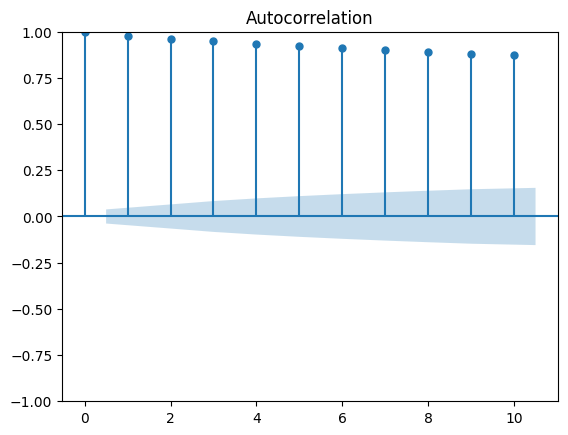

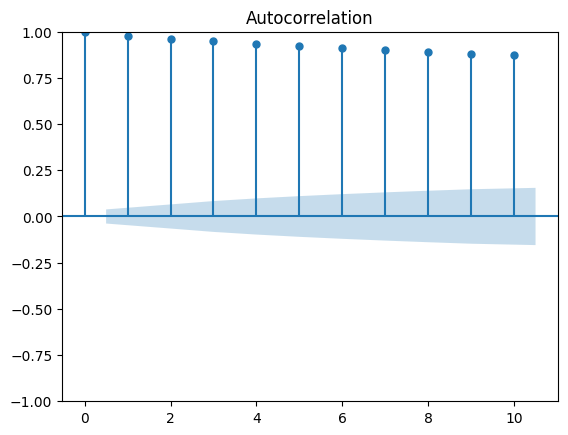

In [115]:
# Plot autocorrelogram for the normalized spread :
plot_acf(z_t_normalized, lags = 10)

Autocorrelogram indicates that there's a strong, positive linear relationship between the current value of the spread and its past values at multiple intervals. The autocorrelation values for all lags are well above the confidence interval band (the blue shaded area), indicating that the correlations are statistically significant

In [116]:
# Run Ljung-Box test
ljung_box_results = acorr_ljungbox(z_t_normalized, lags=[10], return_df=True)
print(ljung_box_results)

       lb_stat  lb_pvalue
10  22405.1757        0.0


$p_{value} = 0$, This would imply that there is significant evidence to suggest that the time series is not random up to lag 10, indicating that past values have a statistically significant effect on future values within this range. The presence of autocorrelation might indicate a predictable pattern (Forecasting) such as momentum or mean reversion. This can be exploited in trading strategies

### Algorithmic Trading Strategy Based on Normalized Spread

The trading strategy is predicated on the normalized spread $z_{\text{normalized}, t}$ and involves two signals for entering and exiting positions:

#### Signal 1: Taking a Short Position in Asset A and a Long Position in Asset B
- **Entry Condition**: Enter a short position in Asset A and a long position in Asset B when $$ z_{\text{normalized}, t} > z_{\text{normalized}, in} $$.
- **Exit Condition**: Close both positions when $$ z_{\text{normalized}, t} \leq 0 $$.
- **Position Size**: The positions are sized as $$ Q_1 = [-1, \beta]' $$, where $\beta $ is the hedge ratio calculated from the cointegration relationship.

#### Signal 2: Taking a Short Position in Asset B and a Long Position in Asset A
- **Entry Condition**: Enter a short position in Asset B and a long position in Asset A when $$ z_{\text{normalized}, t} < - z_{\text{normalized}, in} $$.
- **Exit Condition**: Close both positions when $$ z_{\text{normalized}, t} \geq 0 $$.
- **Position Size**: The positions are sized as $$ Q_2 = [1, -\beta]' $$, where $\beta$ is the hedge ratio.

In both signals, $\beta $ is used to determine the relative amount of Asset B to be traded against Asset A to achieve a market-neutral position, effectively hedging against market movements and focusing on the convergence of the spread.

* We could show that this is not a s.f strategy : The key point is that the amount of Asset A and Asset B being bought or sold is determined by the spread and the dynamic value of $\beta$ which can change over time as the relationship. In conclusion, since the strategy involves dynamic rebalancing which could potentially require additional funds to maintain the desired hedge ratio (as determined by $\beta$), it is not self-financing.


Let's explain the intuition in details the trading startegy :
* $p_{t}^{A} = \alpha + \beta p_{t}^{B} + z_{t}$ , where $\beta$ shows for a unit change of $p_{t}^{B}$, $p_{t}^{A}$ is expected to change by $\beta$ units
* $z_{t}$ :  capture the short-term deviations from the long-term price relationship
* Normalized spread, z-score : $z_{normalized,t} = \frac{z_{t}}{\sigma(z_t)} $  which indicates how many standard deviations away from the regression line (the expected relationship)
* If z_{normalized,t} is above a certain positive threshold, say zinzin​, it suggests Asset A is overpriced relative to its expected value based on Asset B's price and vice versa

* The role of $\beta$ it's the hedge ratio derived from the regression and it determines how much of Asset B to trade against Asset A. By construction for a unit change of $p_{t}^{B}$, $p_{t}^{A}$ is expected to change by $\beta$ units
* By following this strategy, you aim to profit from the temporary mispricing between Asset A and Asset B, based on the assumption that prices will revert to the historical relationship as indicated by the regression. 

***

### Pair-trading Strategy :
* Initial wealth : $W_{0} = \$ 1000$
* At the end of each day, you compute the
signal z̃t using the ajdusted prices at close. If the observed signal requires a trade, you execute
it the next morning at the adjusted price at open.2 Your trading platform requires you to deposit an initial margin of 50% on your short position. That is, if you short-sell 10 units of asset A
with $P^{A}$ = $100, the platform keeps in custody $500. So, with your initial wealth, you can
short-sell a maximum of $Q^{A}$ = 20 units of asset A. In other words, the maximum leverage is 2,
with leverage as $L = P^{A} * Q^{A} /W $.

##### Direct strategy


In [117]:
# Let us re-implement the strategy : #Here we estimate alpha and Beta over the full sample which is not realtistic later we will do a rolling approach
# Step 1 : picking the prices 
# Compute the spread normalized betweem our pairs of assets.
#Run a regression to get the alpha and beta parameters


p_t_A = data_prices['ICTL.HTLS.GP.']            #Prices of asset A 
p_t_B = data_prices['BOOKING HOLDINGS']         #Prices of asset B

#Run regression to estimate alpha and beta

model = sm.OLS(p_t_A, sm.add_constant(p_t_B))
res = model.fit()
alpha, beta = res.params.iloc[0], res.params.iloc[1]


#Compute the spread :
z_t = p_t_A - alpha - beta * p_t_B

#Comute the volatility of the spread
vol_z_t = z_t.std()

#Normalized spread, z_score how many std we are away from the mean of z_t 
z_t_normalized = z_t/vol_z_t

#Threshold
z_tilde_in = 1.5

#print alpha :
print(f'Alpha value of the regression : {alpha:.2f}')
print("Positive alpha")

Alpha value of the regression : 21.28
Positive alpha


In [118]:
#Initializing 

W_0 = 1000                    #Initial wealth
L = 2                         #Maximum leverage
wealth_array = [W_0]          #Wealth tracker
PandL = []                    #P&L tracker

tracking_position = {"Asset A" : 0, "Asset B" :0}
pos_tracker_A = [tracking_position["Asset A"]]
pos_tracker_B = [tracking_position["Asset B"]]
count_short_A, count_short_B = 0,0
for idx_day in(range(len(z_t_normalized) -1)) :

    if (z_t_normalized[idx_day] > z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) :
        count_short_A += 1
        #Open position, Short A and long B
        position = (L * W_0) / p_t_A[idx_day]
        QA = position * -1
        QB = position * beta
        tracking_position["Asset A"] = QA
        tracking_position["Asset B"] = QB
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])
    elif (z_t_normalized[idx_day] <- z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) :
        count_short_B += 1
        #Open position, Long A and Short B
        position = (L * W_0) / (beta*(p_t_B[idx_day] + L*(p_t_A[idx_day] - beta*p_t_B[idx_day])))
        QA = position * 1
        QB = position * -beta
        tracking_position["Asset A"] = QA
        tracking_position["Asset B"] = QB
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])



    #Exit
    elif (tracking_position['Asset A'] < 0 and z_t_normalized[idx_day] <= 0) or (tracking_position['Asset A'] > 0 and z_t_normalized[idx_day] >= 0):
        tracking_position['Asset A'] = 0
        tracking_position['Asset B'] = 0
        wealth_array.append(wealth_array[-1])
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])
        
    #Wealth computation :
    if (tracking_position["Asset A"] !=0) or (tracking_position["Asset B"] !=0) :
        W_new = W_0 + tracking_position["Asset A"] *(p_t_A[idx_day +1] - p_t_A[idx_day]) + tracking_position["Asset B"] *(p_t_B[idx_day +1] - p_t_B[idx_day])
        wealth_array.append(W_new)
        W_0 = W_new
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])

    else :

        wealth_array.append(wealth_array[-1])
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])


    total_num_trades = count_short_A + count_short_B



/tmp/ipykernel_6081/1948453618.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (z_t_normalized[idx_day] > z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) :
/tmp/ipykernel_6081/1948453618.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (z_t_normalized[idx_day] <- z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) :
/tmp/ipykernel_6081/1948453618.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Maximum Wealth: $4200.42
Minimum Wealth: $977.20
Final Profit & Loss (P&L): $3200.42
Total Number of Trades: 11


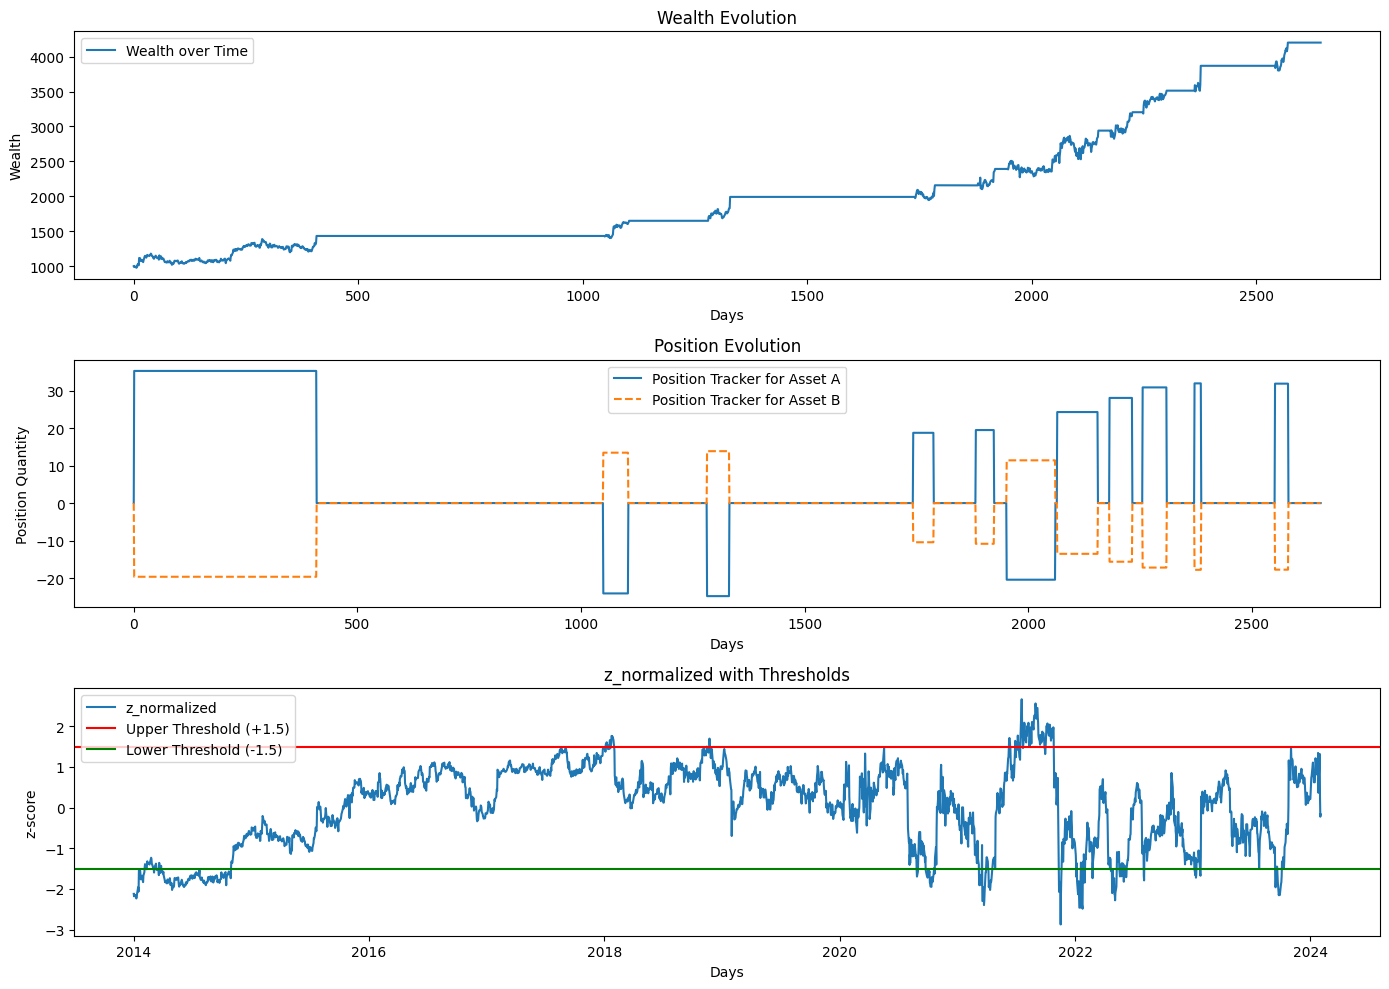

In [119]:
import matplotlib.pyplot as plt

def analyze_and_plot_extended(wealth_array, pos_tracker_A, pos_tracker_B, total_num_trades, z_normalized, z_tilde_in):
    # Print maximum and minimum wealth
    max_wealth = max(wealth_array)
    min_wealth = min(wealth_array)
    print(f"Maximum Wealth: ${max_wealth:.2f}")
    print(f"Minimum Wealth: ${min_wealth:.2f}")

    # Calculate and print Profit and Loss
    final_wealth = wealth_array[-1]
    initial_wealth = wealth_array[0]
    pnl = final_wealth - initial_wealth
    print(f"Final Profit & Loss (P&L): ${pnl:.2f}")
    print(f"Total Number of Trades: {total_num_trades}")

    # Plotting the wealth evolution
    plt.figure(figsize=(14, 10))
    plt.subplot(3, 1, 1)
    plt.plot(wealth_array, label='Wealth over Time')
    plt.title('Wealth Evolution')
    plt.xlabel('Days')
    plt.ylabel('Wealth')
    plt.legend()

    # Plotting the position evolution
    plt.subplot(3, 1, 2)
    plt.plot(pos_tracker_A, label='Position Tracker for Asset A')
    plt.plot(pos_tracker_B, label='Position Tracker for Asset B', linestyle='--')
    plt.title('Position Evolution')
    plt.xlabel('Days')
    plt.ylabel('Position Quantity')
    plt.legend()

    # Plotting z_normalized with thresholds
    plt.subplot(3, 1, 3)
    plt.plot(z_normalized, label='z_normalized')
    plt.axhline(y=z_tilde_in, color='r', linestyle='-', label=f'Upper Threshold (+{z_tilde_in})')
    plt.axhline(y=-z_tilde_in, color='g', linestyle='-', label=f'Lower Threshold (-{z_tilde_in})')
    plt.title('z_normalized with Thresholds')
    plt.xlabel('Days')
    plt.ylabel('z-score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming wealth_array, pos_tracker_A, pos_tracker_B, total_num_trades, z_normalized, and z_tilde_in are defined
analyze_and_plot_extended(wealth_array, pos_tracker_A, pos_tracker_B, total_num_trades, z_t_normalized, z_tilde_in)


Using a stop loss for additional risk mitigation
$z_{stop} = 1.75$

In [120]:


W_0 = 1000                    #Initial wealth
L = 2                         #Maximum leverage
wealth_array = [W_0]          #Wealth tracker
PandL = []                    #P&L tracker

tracking_position = {"Asset A" : 0, "Asset B" :0}
pos_tracker_A = [tracking_position["Asset A"]]
pos_tracker_B = [tracking_position["Asset B"]]
count_short_A, count_short_B = 0,0
z_stop = 1.75       #Stop loss
for idx_day in(range(len(z_t_normalized) -1)) :

    if (z_t_normalized[idx_day] > z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) and (z_t_normalized[idx_day] <= z_stop) :
        count_short_A += 1
        #Open position, Short A and long B
        position = (L * W_0) / p_t_A[idx_day]
        QA = position * -1
        QB = position * beta
        tracking_position["Asset A"] = QA
        tracking_position["Asset B"] = QB
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])
    elif (z_t_normalized[idx_day] <- z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) and (z_t_normalized[idx_day] >= - z_tilde_in):
        count_short_B += 1
        #Open position, Long A and Short B
        position = (L * W_0) / (beta*(p_t_B[idx_day] + L*(p_t_A[idx_day] - beta*p_t_B[idx_day])))
        QA = position * 1
        QB = position * -beta
        tracking_position["Asset A"] = QA
        tracking_position["Asset B"] = QB
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])



    #Exit
    elif (tracking_position['Asset A'] < 0 and z_t_normalized[idx_day] <= 0) or (tracking_position['Asset A'] > 0 and z_t_normalized[idx_day] >= 0):
        tracking_position['Asset A'] = 0
        tracking_position['Asset B'] = 0
        wealth_array.append(wealth_array[-1])
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])
        
    #Wealth computation :
    if (tracking_position["Asset A"] !=0) or (tracking_position["Asset B"] !=0) :
        W_new = W_0 + tracking_position["Asset A"] *(p_t_A[idx_day +1] - p_t_A[idx_day]) + tracking_position["Asset B"] *(p_t_B[idx_day +1] - p_t_B[idx_day])
        wealth_array.append(W_new)
        W_0 = W_new
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])

    else :

        wealth_array.append(wealth_array[-1])
        pos_tracker_A.append(tracking_position["Asset A"])
        pos_tracker_B.append(tracking_position["Asset B"])


    total_num_trades = count_short_A + count_short_B

/tmp/ipykernel_6081/1378337722.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (z_t_normalized[idx_day] > z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) and (z_t_normalized[idx_day] <= z_stop) :
/tmp/ipykernel_6081/1378337722.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif (z_t_normalized[idx_day] <- z_tilde_in) and (tracking_position["Asset A"] == 0) and (tracking_position["Asset B"] == 0) and (z_t_normalized[idx_day] >= - z_tilde_in):
/tmp/ipykernel_6081/1378337722.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a f

Maximum Wealth: $1504.07
Minimum Wealth: $979.05
Final Profit & Loss (P&L): $504.07
Total Number of Trades: 3


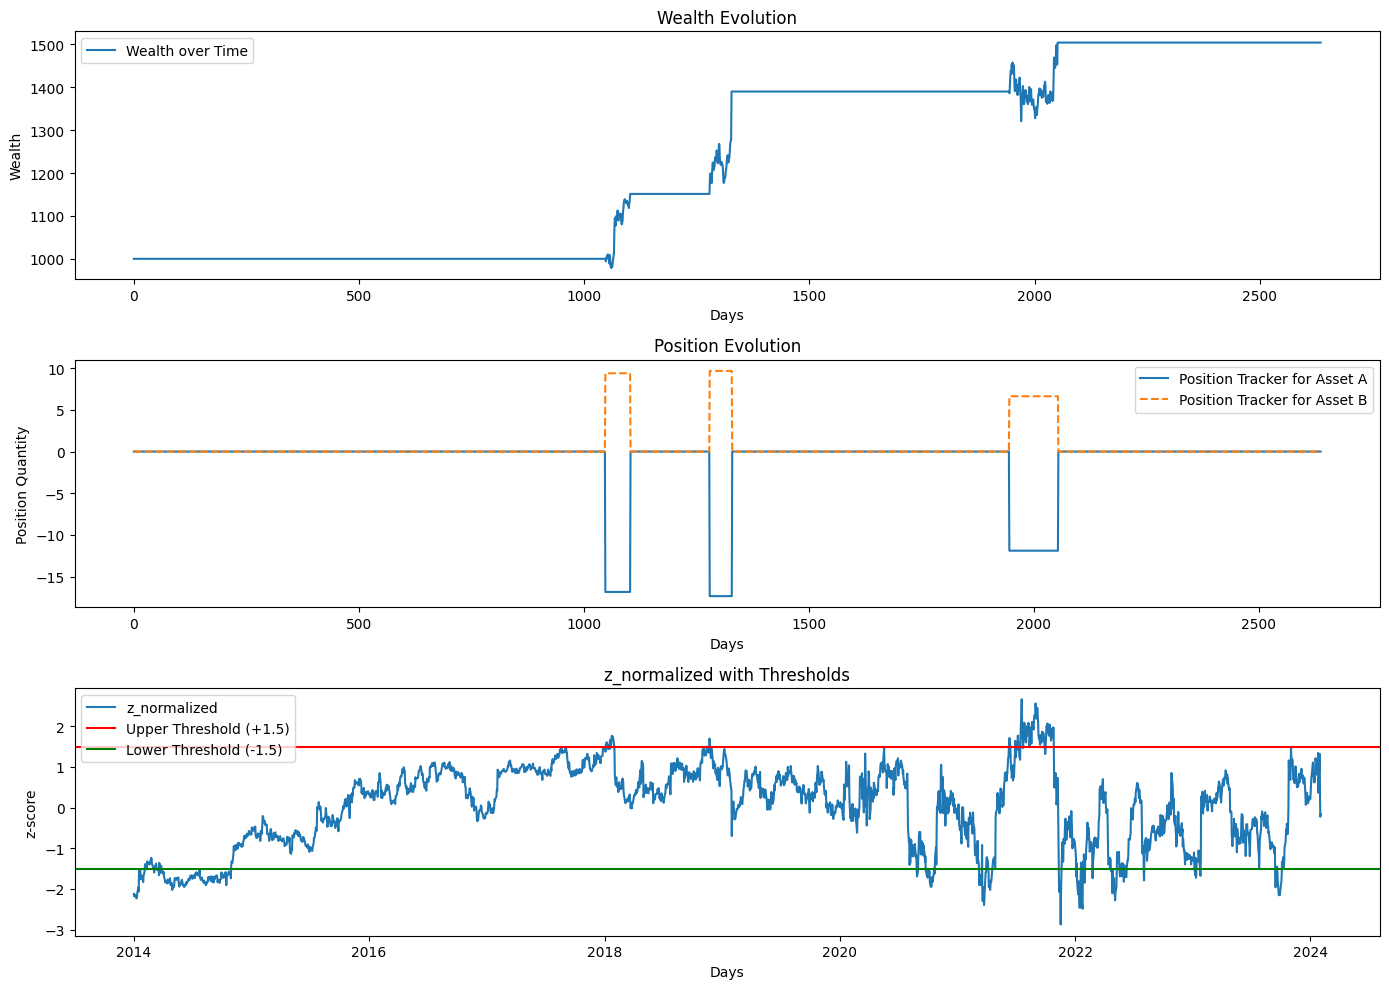

In [121]:
analyze_and_plot_extended(wealth_array, pos_tracker_A, pos_tracker_B, total_num_trades, z_t_normalized, z_tilde_in)

### Rolling approach - More realistic approach

In [123]:
# Estimate alpha and beta over the 1st two years of data (use 500 observations) here we do it statically
start_date = p_t_A.index[0]
end_date = start_date + pd.DateOffset(years = 2)
pA_2years, pB_2years = p_t_A[(p_t_A.index >= start_date) & (p_t_A.index <= end_date)], p_t_B[(p_t_B.index >= start_date) & (p_t_B.index <= end_date)]

model = sm.OLS(pA_2years, sm.add_constant(pB_2years))
res = model.fit()
alpha,beta = res.params

#spread computed for 20 day after the end_date

spread_end_date = end_date + pd.DateOffset(days = 20)


pA_test, pB_test = p_t_A[(p_t_A.index > end_date) & (p_t_A.index <= spread_end_date)], p_t_B[(p_t_B.index > end_date) & (p_t_B.index <= spread_end_date)]

spread = pA_test - alpha - beta* pB_test

